**Савин Александр М80-407Б-19**   
Алгоритм: Случайный лес  
Ссылка на dataset: https://www.kaggle.com/datasets/jimschacko/airlines-dataset-to-predict-a-delay

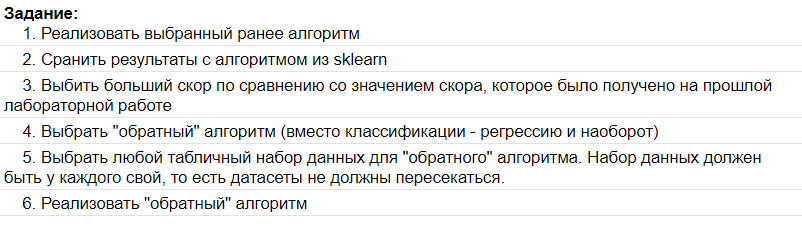

---

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("ggplot")  #using style ggplot
import math

import io

In [2]:
import warnings
warnings.filterwarnings('ignore')

---

Импортируем датасет

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Airlines.csv to Airlines.csv


In [ ]:
print (uploaded['Airlines.csv'][:200].decode('utf-8') + '...')
df = pd.read_csv(io.StringIO(uploaded['Airlines.csv'].decode('utf-8')))

id,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay
1,CO,269,SFO,IAH,3,15,205,1
2,US,1558,PHX,CLT,3,15,222,1
3,AA,2400,LAX,DFW,3,20,165,1
4,AA,2466,SFO,DFW,3,20,195,1
5,AS,108,ANC,SEA,...


---

In [ ]:
df = df.rename(columns = {"Delay":"Target"})
model_features = df.columns.drop("Target")
model_target = "Target"

numerical_features_all = df[model_features].select_dtypes(include=np.number).columns
categorical_features_all = df[model_features].select_dtypes(include = "object").columns

---

In [3]:
import seaborn as sns

import plotly.express as px
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier

---

Подготовка данных

In [ ]:
df.isnull().sum()

id             0
Airline        0
Flight         0
AirportFrom    0
AirportTo      0
DayOfWeek      0
Time           0
Length         0
Target         0
dtype: int64

In [ ]:
le = preprocessing.LabelEncoder()

df['Airline'] = le.fit_transform(df['Airline'])
df['AirportFrom'] = le.fit_transform(df['AirportFrom'])
df['AirportTo'] = le.fit_transform(df['AirportTo'])

X = pd.DataFrame({'DayOfWeek': df['DayOfWeek'],
                'Time': df['Time'],
                'Length': df['Length']            
               })
y = df['Target']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, stratify = y)

Собственная реализация случайного леса

In [ ]:
from typing import Tuple
class BinaryTree():
    def __init__(self):
        self.children_left = []
        self.children_right = []
    
    @property
    def n_leaves(self):
        return self.children_left.count(-1) 
    
    def add_node(self):
        self.children_left.append(-1)
        self.children_right.append(-1)
    
    def set_left_child(self, node_id: int, child_id: int):
        self.children_left[node_id] = child_id

    def set_right_child(self, node_id: int, child_id: int):
        self.children_right[node_id] = child_id

    def get_children(self, node_id: int) -> Tuple[int]: 
        return self.children_left[node_id], self.children_right[node_id]

    def is_leaf(self, node_id: int) -> bool:
        return self.children_left[node_id] == self.children_right[node_id] #==-1

In [ ]:
from sklearn.utils import check_random_state
from sklearn.preprocessing import OneHotEncoder
from typing import List
from itertools import combinations

class DecisionTree:
    def __init__(self, max_depth=None, max_features=None, min_samples_leaf=1, random_state=None):
        self.max_depth = max_depth
        self.max_features = max_features
        self.min_samples_leaf = min_samples_leaf
        self.RandomState = check_random_state(random_state)

        # initialise internal variables
        self.tree_ = BinaryTree() 
        self.n_samples = []
        self.values = []
        self.impurities = []
        self.split_features = []
        self.split_values = []
        self.size = 0 # current node = size - 1
		
    def split_name(self, node_id: int) -> str:
        return self.features[self.split_features[node_id]]

    def fit(self, X, Y):
        if Y.ndim == 1:
            Y = OneHotEncoder(Y) # one-hot encoded y variable

        # set internal variables
        self.n_features = X.shape[1]
        self.n_classes = Y.shape[1]
        self.features = X.columns
        self.max_depth_ = float('inf') if self.max_depth is None else self.max_depth
        self.n_features_split = self.n_features if self.max_features is None else self.max_features
        # initial split which recursively calls itself
        self._split_node(X, Y, 0)  

        # set attributes
        self.feature_importances_ = self.impurity_feature_importance()

    def _set_defaults(self, node_id: int, Y):
        val = Y.sum(axis=0)
        self.values.append(val)
        self.impurities.append(gini_score(val))
        self.split_features.append(None)
        self.split_values.append(None)
        self.n_samples.append(Y.shape[0])
        self.tree_.add_node()

    def _split_node(self, X, Y, depth: int):
        node_id = self.size
        self.size += 1
        self._set_defaults(node_id, Y)
        if self.impurities[node_id] == 0: # only one class in this node
            return
      
        # random shuffling removes any bias due to the feature order
        features = self.RandomState.permutation(self.n_features)[:self.n_features_split]

        # make the split
        best_score = float('inf')
        for i in features:
            best_score = self._find_bettersplit(i, X, Y, node_id, best_score)
        if best_score == float('inf'): # a split was not made
            return 

        # make children
        if depth < self.max_depth_: 
            x_split = X.values[:, self.split_features[node_id]]
            lhs = np.nonzero(x_split<=self.split_values[node_id])
            rhs = np.nonzero(x_split> self.split_values[node_id])
            self.tree_.set_left_child(node_id, self.size)
            self._split_node(X.iloc[lhs], Y[lhs[0], :], depth+1)
            self.tree_.set_right_child(node_id, self.size)
            self._split_node(X.iloc[rhs], Y[rhs[0], :], depth+1)

    def _find_bettersplit(self, var_idx: int, X, Y, node_id: int, best_score: float) -> float:
        X = X.values[:, var_idx] 
        n_samples = self.n_samples[node_id]

        # sort the variables.
        order = np.argsort(X)
        X_sort, Y_sort = X[order], Y[order, :]

        # Start with all on the right. Then move one sample to the left one at a time
        rhs_count = Y.sum(axis=0)
        lhs_count = np.zeros(rhs_count.shape)
        for i in range(0, n_samples-1):
            xi, yi = X_sort[i], Y_sort[i, :]
            lhs_count += yi;  rhs_count -= yi
            if (xi == X_sort[i+1]) or (sum(lhs_count) < self.min_samples_leaf):
                continue
            if sum(rhs_count) < self.min_samples_leaf:
                break
            # Gini Impurity
            curr_score = (gini_score(lhs_count) * sum(lhs_count) + gini_score(rhs_count) * sum(rhs_count))/n_samples
            if curr_score < best_score:
                best_score = curr_score
                self.split_features[node_id] = var_idx
                self.split_values[node_id]= (xi + X_sort[i+1])/2
        return best_score

    def impurity_feature_importance(self):
        feature_importances = np.zeros(self.n_features)
        total_samples = self.n_samples[0]
        for node in range(len(self.impurities)):
            if self.tree_.is_leaf(node):
                continue 
            spit_feature = self.split_features[node]
            impurity = self.impurities[node]
            n_samples = self.n_samples[node]
            # calculate score
            left, right = self.tree_.get_children(node)
            lhs_gini = self.impurities[left]
            rhs_gini = self.impurities[right]
            lhs_count = self.n_samples[left]
            rhs_count = self.n_samples[right]
            score = (lhs_gini * lhs_count + rhs_gini * rhs_count)/n_samples
            # feature_importances  = (decrease in node impurity) * (probability of reaching node ~ proportion of samples)
            feature_importances[spit_feature] += (impurity-score) * (n_samples/total_samples)

            return feature_importances/feature_importances.sum() 
    def _predict_batch(self, X, node=0):
            if self.tree_.is_leaf(node):
                return self.values[node]
            if len(X) == 0:
                return np.empty((0, self.n_classes))
            left, right = self.tree_.get_children(node)

            lhs = X[:, self.split_features[node]] <= self.split_values[node]
            rhs = X[:, self.split_features[node]] >  self.split_values[node]

            probs = np.zeros((X.shape[0], self.n_classes))
            probs[lhs] = self._predict_batch(X[lhs], node=left)
            probs[rhs] = self._predict_batch(X[rhs], node=right)
            return probs

    def predict_prob(self, X):
        probs = self._predict_batch(X.values)
        probs /= np.sum(probs, axis=1)[:, None] # normalise along each row (sample)
        return probs

    def predict(self, X):
        probs = self.predict_prob(X)
        return np.nanargmax(probs, axis=1)


def gini_score(counts): return 1 - sum([c*c for c in counts])/(sum(counts)*sum(counts))


In [ ]:
import warnings
class MyRandomForestClassifier:
    def __init__(self, n_trees=100, random_state=None, max_depth=None,  
                 max_features=None, min_samples_leaf=1, sample_size=None, 
                 bootstrap=True,  oob_score=False):
        self.n_trees = n_trees
        self.RandomState = check_random_state(random_state)
        self.max_depth = max_depth
        self.max_features = max_features
        self.min_samples_leaf=min_samples_leaf
        self.sample_size = sample_size
        self.bootstrap = bootstrap
        self.oob_score = oob_score

    def fit(self, X, Y):
        if Y.ndim == 1:
            one = OneHotEncoder()
            transformed = one.fit_transform(Y.values.reshape(-1, 1))
            Y = transformed.toarray()
            
        # set internal variables
        self.n_features = X.shape[1]
        self.n_classes = Y.shape[1]
        self.features = X.columns
        n_samples = X.shape[0]
        self.sample_size_ = n_samples if self.sample_size is None else self.sample_size

        # create decision trees
        self.trees = []
        rng_states = [] # save the random states to regenerate the random indices for the oob_score
        for i in range(self.n_trees):
            rng_states.append(self.RandomState.get_state())
            self.trees.append(self.create_tree(X, Y))

        # set attributes
        self.feature_importances_ = self.impurity_feature_importances()
        if self.oob_score:
            if not (self.bootstrap or (self.sample_size_<n_samples)):
                    warnings.warn("out-of-bag score will not be calculated because bootstrap=False")
            else:
                self.oob_score_ = self.calculate_oob_score(X, Y, rng_states)

    def create_tree(self, X, Y):
        assert len(X) == len(Y), ""
        n_samples = X.shape[0]

        # get sub-sample 
        if self.bootstrap: # sample with replacement
            rand_idxs = self.RandomState.randint(0, n_samples, self.sample_size_) 
            X_, Y_ = X.iloc[rand_idxs, :], Y[rand_idxs] #
        elif self.sample_size_ < n_samples: # sample without replacement
            rand_idxs = self.RandomState.permutation(np.arange(n_samples))[:self.sample_size_]  
            X_, Y_ = X.iloc[rand_idxs, :], Y[rand_idxs]
        else:
            X_, Y_ = X.copy(), Y.copy() # do nothing to the data

        new_tree =  DecisionTree(max_depth=self.max_depth, 
                                max_features=self.max_features,
                                random_state=self.RandomState,
                                min_samples_leaf=self.min_samples_leaf
                                )
        new_tree.fit(X_, Y_)
        return new_tree

    def impurity_feature_importances(self) -> np.ndarray:
        feature_importances = np.zeros((self.n_trees, self.n_features))

        for i, tree in enumerate(self.trees):
            feature_importances[i, :] = tree.feature_importances_

        return np.mean(feature_importances, axis=0)

    def predict(self, X) -> np.ndarray:
        probs = np.sum([t.predict_prob(X) for t in self.trees], axis=0)
        return np.nanargmax(probs, axis=1)

    def score(self, X, y) -> float:
        y_pred = self.predict(X)
        return np.mean(y_pred==y)

In [ ]:
rfc = MyRandomForestClassifier(n_trees=10, bootstrap=True, max_features=2, min_samples_leaf=3)
rfc.fit(X_train, y_train)

In [ ]:
prediction = rfc.predict(X_test)

In [ ]:
rfc.score(X_test, y_test)

0.5979977134381855

---

Библиотечная реализация

In [ ]:
clf = RandomForestClassifier(n_estimators = 100) 
clf.fit(X_train, y_train)

RandomForestClassifier()

In [ ]:
y_pred = clf.predict(X_test)

In [ ]:
clf.score(X_test, y_test)

0.5850322899607576

In [ ]:
from sklearn import metrics
print("Accuracy metric : ", metrics.accuracy_score(y_test, y_pred))
print("MAE metric:", metrics.mean_absolute_error(y_test, y_pred))
print("MSE metric:", metrics.mean_squared_error(y_test, y_pred))

Accuracy metric :  0.5850322899607576
MAE metric: 0.4149677100392423
MSE metric: 0.4149677100392423


----

Обратный алгоритм - Линейная регрессия

In [11]:
import seaborn as sns

import plotly.express as px
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier

In [3]:
from google.colab import files
uploaded2 = files.upload()

Saving diamonds.csv to diamonds (4).csv


In [4]:
print (uploaded2['diamonds.csv'][:200].decode('utf-8') + '...')
df = pd.read_csv(io.StringIO(uploaded2['diamonds.csv'].decode('utf-8')))

"","carat","cut","color","clarity","depth","table","price","x","y","z"
"1",0.23,"Ideal","E","SI2",61.5,55,326,3.95,3.98,2.43
"2",0.21,"Premium","E","SI1",59.8,61,326,3.89,3.84,2.31
"3",0.23,"Good","E"...


In [5]:
df.head()

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [6]:
df.isnull().sum()

Unnamed: 0    0
carat         0
cut           0
color         0
clarity       0
depth         0
table         0
price         0
x             0
y             0
z             0
dtype: int64

In [7]:
cat_var =  ['cut', 'color', 'clarity']

for i in range (0, len(cat_var)):
    print(f'Unique Values for {cat_var[i]}', df[f'{cat_var[i]}'].unique())

Unique Values for cut ['Ideal' 'Premium' 'Good' 'Very Good' 'Fair']
Unique Values for color ['E' 'I' 'J' 'H' 'F' 'G' 'D']
Unique Values for clarity ['SI2' 'SI1' 'VS1' 'VS2' 'VVS2' 'VVS1' 'I1' 'IF']


In [8]:
df

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75
...,...,...,...,...,...,...,...,...,...,...,...
53935,53936,0.72,Ideal,D,SI1,60.8,57.0,2757,5.75,5.76,3.50
53936,53937,0.72,Good,D,SI1,63.1,55.0,2757,5.69,5.75,3.61
53937,53938,0.70,Very Good,D,SI1,62.8,60.0,2757,5.66,5.68,3.56
53938,53939,0.86,Premium,H,SI2,61.0,58.0,2757,6.15,6.12,3.74


In [12]:
X = df.drop(["price"],axis = 1)
X = X.drop(['cut'], axis = 1)
X = X.drop(['color'], axis = 1)
X = X.drop(['clarity'], axis = 1)
y = df["price"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 101)

In [13]:
X_test

,Unnamed: 0,carat,depth,table,x,y,z
46519,46520,0.51,62.7,54.0,5.10,5.08,3.19
8639,8640,1.06,61.9,59.0,6.52,6.50,4.03
23029,23030,0.33,61.3,56.0,4.51,4.46,2.75
51641,51642,0.31,63.1,58.0,4.30,4.35,2.73
25789,25790,2.04,58.8,60.0,8.42,8.32,4.92
...,...,...,...,...,...,...,...
26078,26079,2.04,60.0,60.0,8.30,8.26,4.97
26584,26585,2.24,61.4,56.0,8.38,8.43,5.16
35767,35768,0.40,62.6,57.0,4.70,4.73,2.95
29891,29892,0.30,61.8,55.0,4.30,4.34,2.67


In [14]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [16]:
X_train

array([[-0.98334229,  0.89163273, -0.80500329, ...,  1.05266837,
         1.00694056,  0.91048772],
       [ 0.52635893, -0.81676046,  0.59102181, ..., -0.91682899,
        -0.86685116, -0.83081597],
       [ 1.66012639, -0.52148263, -0.38619576, ..., -0.40885908,
        -0.39394182, -0.4422606 ],
       ...,
       [-0.59457803,  0.4276247 ,  0.87022683, ...,  0.56252197,
         0.59649094,  0.69462363],
       [-0.58264566,  0.4276247 ,  0.24201554, ...,  0.54469846,
         0.64110503,  0.62266893],
       [ 1.21285503, -0.56366518, -0.10699074, ..., -0.48906486,
        -0.46532436, -0.48543342]])

In [15]:
model = LinearRegression(copy_X='True', fit_intercept='True', normalize=True, positive='True', n_jobs = -1)
model.fit(X_train, y_train)
pred = model.predict(X_test)
 
train_score = model.score(X_train, y_train)
print(f'Train score of trained model: {train_score}')

test_score = model.score(X_test, y_test)
print(f'Test score of trained model: {test_score}')

Train score of trained model: 0.850828966490882
Test score of trained model: 0.8533542620520005


---

Собственная релазация линейной регрессии 

In [70]:
from sklearn.base import BaseEstimator, ClassifierMixin

class Linear(BaseEstimator, ClassifierMixin):
    def __init__(self, lr, nepoch, batch_size):
        self.lr = lr
        self.nepoch = nepoch
        self.batch_size = batch_size
        pass
    
    def sigmoid(self, x):
        self.l = 1 / (1 + np.exp(-x))
        return self.l
        
    def fit(self, data, labels):
        data = np.concatenate((data, np.ones((data.shape[0],1))), axis = 1)
        self.W = np.random.normal(0, 1, (len(data[0]),))
        
        for i in range(self.nepoch):
            for i in range(0, len(data), self.batch_size):
                xb = data[i:i + self.batch_size]
                yb = labels[i:i + self.batch_size]
                p = np.dot(self.W, xb.T)
                s = self.sigmoid(p)
                dp = np.dot(xb.T, (s - yb).T)
                self.W -= self.lr * dp
        
    def predict(self, maindata):
        maindata = np.concatenate((maindata, np.ones((maindata.shape[0],1))), axis = 1)
        p = np.dot(self.W, maindata.T)
        s = self.sigmoid(p)
        return s
        
    def score(self, X_test, y_test1):
      prediction = model.predict(X_test)
      acc = 0
      for i in range(len(y_test1)):
        acc += (math.fabs(prediction[i] - y_test1[i]))
      return acc / len(X_test)

In [71]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
y_train1 = scaler.fit_transform(pd.DataFrame(y_train.values.reshape(-1,1)))
y_test1 = scaler.fit_transform(pd.DataFrame(y_test.values.reshape(-1,1)))

In [72]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import max_error
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import RocCurveDisplay
from sklearn.linear_model import SGDClassifier

In [73]:
model = Linear(lr = 0.01, nepoch = 1000, batch_size = 1)
model.fit(X_train, y_train.values)
prediction = model.predict(X_test)
model.score(X_test, y_test1)

0.8375696743372454